# Compare the free energy by direct versus indirect minimisation
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Content**
In this notebook I will apply the schematic from the 'Essentials.ipynb' and 'Minimisation_F.ipynb' files to compute the min_energy, max_entropy and free_energy from the dataset. I compare the direct versus indirect minimisation of free energy, i.e. min[F(p)] versus min[U(p)] - T*max[S(p)].

In [58]:
# Import necessary libraries
import numpy as np
import glob

# Import external background functions
%run background_functions.py

In [2]:
# Import HCP data
matrices = [np.genfromtxt(file) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]

In [3]:
# Define desired settings
cutoff=0.8 # Value between 0 and 1. Values below this value are set to zero. Becomes obsolete after including phase randomisation
max_dim=4

In [51]:
euler_characteristic, clique_complex = compute_euler(matrices[0],cutoff,max_dim)
#clique_complex = [{1,2},{1},{2}]
matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

Compare optimisation parameters for one subject

In [59]:
# Example for generating energy and entropy data from a given matrix
list_size = len(inverse_connectivity_matrix)
num_iterations_free_energy = 100
num_iterations_energy = 20000
num_iterations_entropy = 1000
sampling_distributions = ['uniform', 'normal', 'chisquare', 'gamma', 'lognormal', 'pareto']
free_energy_probabilities = []
energy_probabilities = []
entropy_probabilities = []
energy_probabilities_test = []

for _ in sampling_distributions:
    initial_probabilities = generate_probability_list(list_size, _)
    # Minimum helmholtz free energy
    free_energy_history, current_probabilities_energy = simulated_annealing_free_energy(initial_probabilities, _, -0.1, inverse_connectivity_matrix, num_iterations_free_energy, initial_temperature=1.0, cooling_rate=0.95)
    # Minimum internal energy
    energy_history, current_probabilities_energy = simulated_annealing_energy(initial_probabilities, _ , -0.1, inverse_connectivity_matrix, num_iterations_energy)
    # Maximum shannon entropy
    entropy_history, current_probabilities_entropy = simulated_annealing_entropy(initial_probabilities, _ , -0.1, num_iterations_entropy)

    # Store probabilities type
    free_energy_probabilities.append(free_energy_history)
    energy_probabilities.append(energy_history)
    entropy_probabilities.append(entropy_history)

    energy_probabilities_test.append(current_probabilities_energy)

In [60]:
print(np.sum(energy_probabilities_test[5]))
print(max(energy_probabilities_test[5]))
print(min(energy_probabilities_test[5]))
print(energy_probabilities_test)

1.0
0.8038192651947287
5.038912860539058e-07
[array([6.55903758e-03, 8.37692518e-03, 4.24105007e-03, 6.91069641e-03,
       7.64580732e-03, 9.02612997e-03, 4.35499010e-03, 5.85739624e-03,
       7.93959625e-03, 8.45816303e-03, 1.56745504e-03, 1.97207269e-03,
       2.08176196e-03, 4.64607925e-03, 6.41481528e-03, 1.33823623e-03,
       3.07929047e-03, 9.44832539e-03, 5.79563934e-03, 2.85829149e-03,
       1.49845799e-03, 5.05492481e-03, 6.24159456e-03, 3.07227083e-03,
       4.46336731e-03, 7.18817506e-03, 3.06276034e-03, 5.98846674e-03,
       6.08101450e-03, 8.27409384e-03, 1.02366382e-02, 2.92490011e-03,
       1.00875893e-02, 1.97556555e-03, 1.80078449e-04, 1.29253055e-03,
       9.88489517e-03, 4.39153432e-03, 8.71525984e-03, 7.37844448e-03,
       2.52494694e-03, 3.80123474e-03, 5.61578503e-03, 5.65104670e-03,
       1.00454390e-02, 3.77765647e-03, 4.92742830e-03, 3.99534467e-03,
       5.82956033e-03, 8.97033221e-04, 2.30950586e-03, 5.01081675e-04,
       7.86112939e-04, 2.621232

In [61]:
# Generate the theoretical max_entropy and min_energy to compare numerical results
max_entropy_value, min_energy_value = analytical_functionals(matrix, cutoff, max_dim)
max_entropy = [max_entropy_value]*num_iterations_entropy
min_energy = [min_energy_value]*num_iterations_energy

In [62]:
min_energy_value_approximation = energy_function(energy_probabilities_test[5], inverse_connectivity_matrix)
print(min_energy_value_approximation)
print(min_energy_value)
min_energy_approximation = [min_energy_value_approximation]*num_iterations_energy

-0.6446256531928848
8.44594594594589e-05


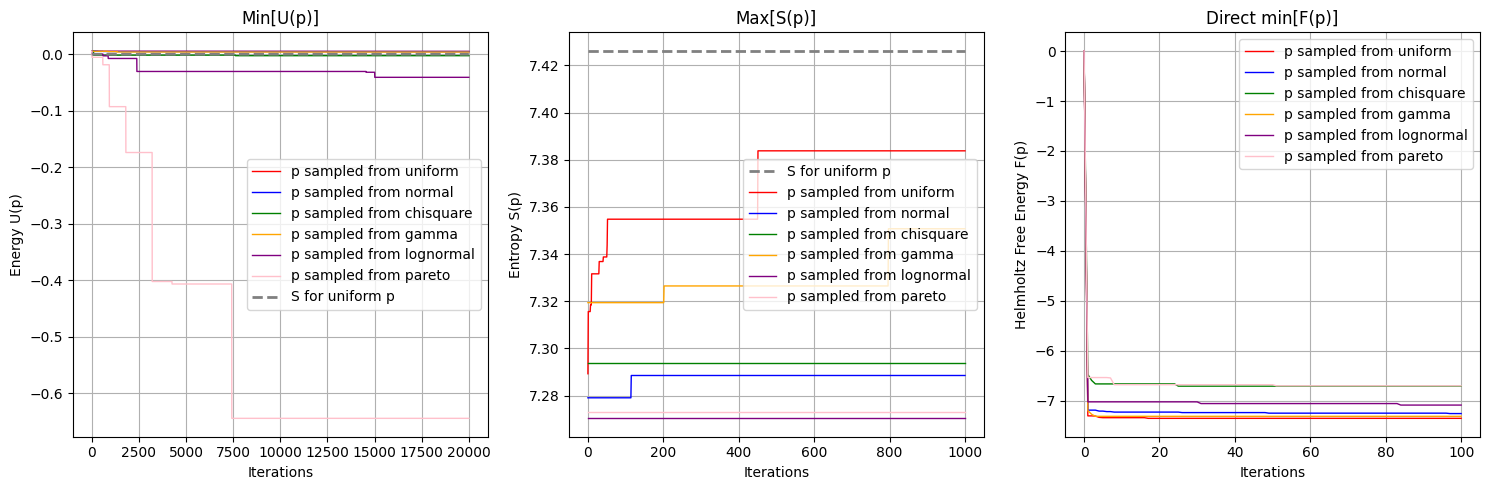

In [63]:
# Plotting the optimisation side by side
plt.figure(figsize=(15, 5))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown']

# Plot the energy/entropy evolution against the number of Simulated Annealing iterations

plt.subplot(1, 3, 1)
for i in range(len(sampling_distributions)):
    plt.plot(energy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'p sampled from {sampling_distributions[i]}')
plt.plot(min_energy, color='grey', linestyle='--', linewidth = 2, label='S for uniform p')
plt.title('Min[U(p)]')
plt.xlabel('Iterations')
plt.ylabel('Energy U(p)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(max_entropy, color='grey', linestyle='--', linewidth = 2, label='S for uniform p')
for i in range(len(sampling_distributions)):
    plt.plot(entropy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'p sampled from {sampling_distributions[i]}')
plt.title('Max[S(p)]')
plt.xlabel('Iterations')
plt.ylabel('Entropy S(p)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
for i in range(len(sampling_distributions)):
    plt.plot(free_energy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'p sampled from {sampling_distributions[i]}')
plt.title('Direct min[F(p)]')
plt.xlabel('Iterations')
plt.ylabel('Helmholtz Free Energy F(p)')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

For internal energy minimisation pareto seems the best. Test parameters to find the best settings. For the entropy and free energy the uniform distribution are the best, so no additional settings are required. Notice that the free energy minimisation seems to converge much quicker than the other functionals.

In [17]:
# Example for generating energy and entropy data from a given matrix
list_size = len(inverse_connectivity_matrix)
num_iterations_energy = 5000
num_iterations_entropy = 5000
energy_probabilities = []
entropy_probabilities = []
pareto_constants = [-0.1, -0.3, -0.6, -0.9]
cooling_rates = [0.99, 0.9, 0.6, 0.3, 0.1]

for pareto_constant in pareto_constants:
    initial_probabilities = generate_probability_list(list_size, 'genpareto')
    # Minimum internal energy with simulated annealing
    energy_history, current_probabilities_energy = simulated_annealing_energy(initial_probabilities, 'genpareto' , pareto_constant, inverse_connectivity_matrix, num_iterations_energy)
    # Store probabilities type
    energy_probabilities.append(energy_history)

for current_cooling_rate in cooling_rates:
    initial_probabilities = generate_probability_list(list_size, 'genpareto')
    # Minimum internal energy with simulated annealing
    energy_history, current_probabilities_energy = simulated_annealing_energy(initial_probabilities, 'genpareto' , -0.1, inverse_connectivity_matrix, num_iterations_energy, cooling_rate=current_cooling_rate)
    # Store probabilities type
    entropy_probabilities.append(energy_history)

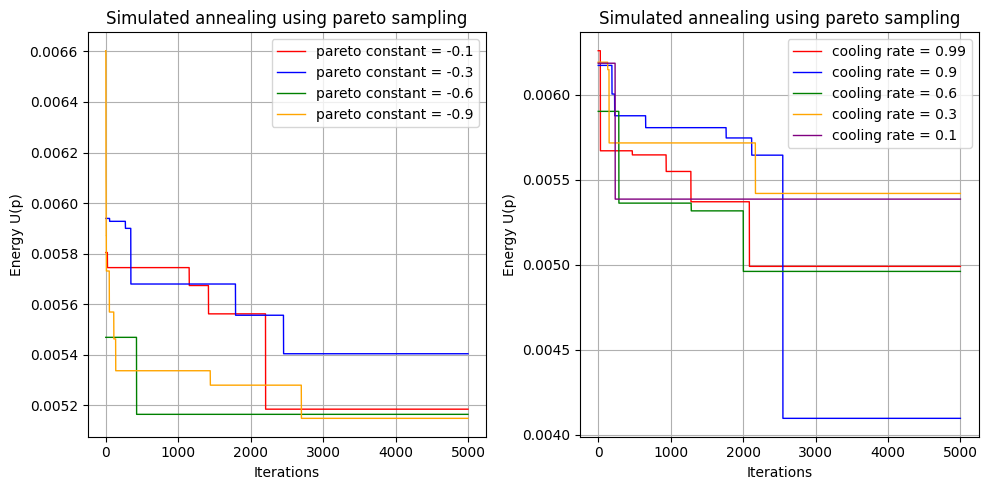

In [18]:
# Plotting the optimisation side by side
plt.figure(figsize=(10, 5))
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Plot the energy/entropy evolution against the number of Simulated Annealing iterations

plt.subplot(1, 2, 1)
for i in range(len(pareto_constants)):
    plt.plot(energy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'pareto constant = {pareto_constants[i]}')
plt.title('Simulated annealing using pareto sampling')
plt.xlabel('Iterations')
plt.ylabel('Energy U(p)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(len(cooling_rates)):
    plt.plot(entropy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'cooling rate = {cooling_rates[i]}')
plt.title('Simulated annealing using pareto sampling')
plt.xlabel('Iterations')
plt.ylabel('Energy U(p)')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

Generate free energy from direct versus indirect minimisation for all subjects

In [15]:
free_energy_direct = []
free_energy_indirect = []
free_energy_analytical = []

for matrix in matrices:
    # Compute direct free energy
    free_energy_subject_1 = computing_functionals_direct(matrix, cutoff, max_dim)
    free_energy_direct.append(free_energy_subject_1)

    # Compute indirect free energy
    U_min, p_Umin, S_max, p_Smax, free_energy_subject_2 = computing_functionals(matrix,cutoff,max_dim)
    free_energy_indirect.append(free_energy_subject_2)

    # Compute analytical free energy
    max_entropy_value, min_energy_value = analytical_functionals(matrix, cutoff, max_dim)
    free_energy_subject_3 = min_energy_value - max_entropy_value
    free_energy_analytical.append(free_energy_subject_3)

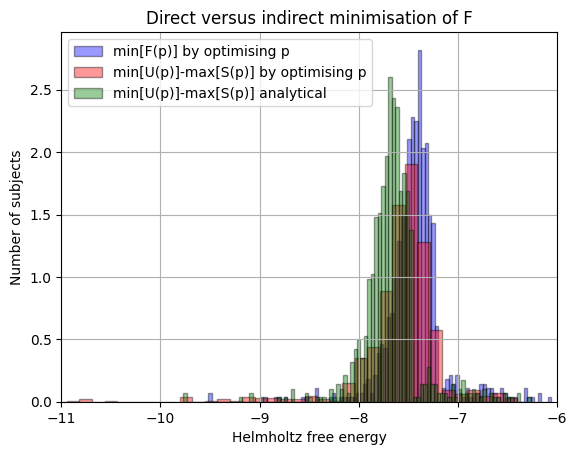

In [16]:
plt.hist(free_energy_direct, bins=100, density=True, alpha=0.4, color='blue', edgecolor='black', label= 'min[F(p)] by optimising p')
plt.hist(free_energy_indirect, bins=100, density=True, alpha=0.4, color='red', edgecolor='black', label = 'min[U(p)]-max[S(p)] by optimising p')
plt.hist(free_energy_analytical, bins=100, density=True, alpha=0.4, color='green', edgecolor='black', label = 'min[U(p)]-max[S(p)] analytical')
plt.xlim(-11, -6)
plt.grid(True)
plt.title('Direct versus indirect minimisation of F')
plt.ylabel('Number of subjects')
plt.xlabel('Helmholtz free energy')
plt.legend()
plt.show()

Why does the direct method converge so much faster (almost instanteneously) compared to the indirect method? And if the direct method is truly close to the minimal free energy, why is there no convergence between distribution types?

In [173]:
clique_complex = [{1,2},{1},{2}]
matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)
print(matrix)
print(inverse_connectivity_matrix)

[[1. 1. 1.]
 [1. 1. 0.]
 [1. 0. 1.]]
[[-1.  1.  1.]
 [ 1. -0. -1.]
 [ 1. -1. -0.]]


In [181]:
print('Energy with p from uniform sampling', energy_function([9.88143162e-01, 6.52177854e-04, 1.12046603e-02],inverse_connectivity_matrix))
print('Energy with p from normal sampling', energy_function([9.97991227e-01, 4.05999969e-04, 1.60277305e-03],inverse_connectivity_matrix))
print('Energy with p from chisquare sampling', energy_function([9.99982503e-01, 4.93987032e-07, 1.70030982e-05],inverse_connectivity_matrix))
print('Energy with p from gamma sampling', energy_function([0.94708286, 0.00748423, 0.04543291],inverse_connectivity_matrix))
print('Energy with p from lognormal sampling', energy_function([0.98322292, 0.011446  , 0.00533109],inverse_connectivity_matrix))
print('Energy with p from pareto sampling', energy_function([9.98311474e-01, 7.87624936e-04, 9.00901418e-04],inverse_connectivity_matrix))
print('Energy with p acc to Knill', energy_function([3/7, 2/7, 2/7],inverse_connectivity_matrix))

print('Entropy with p acc to Knill', shannon_entropy([1/3,1/3,1/3]))

Energy with p from uniform sampling -0.9530090163803451
Energy with p from normal sampling -0.9919783149205901
Energy with p from chisquare sampling -0.9999300127647727
Energy with p from gamma sampling -0.7974121718133572
Energy with p from lognormal sampling -0.9338581108878008
Energy with p from pareto sampling -0.9932558677981969
Energy with p acc to Knill 0.14285714285714285
Entropy with p acc to Knill 0.5283208335737187


explore bifurcation?

In [186]:
F_list = []
B_list = []

for B in np.arange(0, 1, 0.01):
    B_list.append(B)
    F = B*0.14285714285714285 - (1-B)*0.5283208335737187
    F_list.append(F)

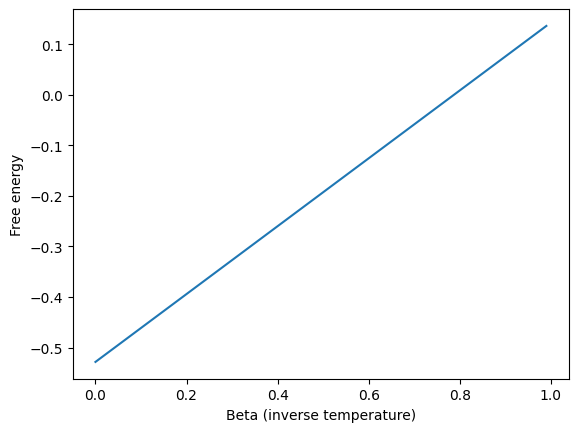

In [190]:
plt.plot(B_list, F_list)
plt.xlabel('Beta (inverse temperature)')
plt.ylabel('Free energy')
plt.show()

In [20]:
clique_complex = [{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23}, {24}, {25}, {26}, {27}, {28}, {29}, {30}, {31}, {32}, {33}, {34}, {35}, {36}, {37}, {38}, {39}, {40}, {41}, {42}, {43}, {44}, {45}, {46}, {47}, {48}, {49}, {50}, {51}, {52}, {53}, {54}, {55}, {56}, {57}, {58}, {59}, {60}, {61}, {62}, {63}, {64}, {65}, {66}, {67}, {68}, {69}, {70}, {71}, {72}, {73}, {74}, {75}, {76}, {77}, {78}, {79}, {80}, {81}, {82}, {83}, {84}, {85}, {86}, {87}, {88}, {89}, {90}, {91}, {92}, {93}, {94}, {95}, {96}, {97}, {98}, {99}, {100}, {101}, {102}, {103}, {104}, {105}, {106}, {107}, {108}, {109}, {110}, {111}, {112}, {113}, {114}, {115}, {116}, {117}, {118}, {119}, {120}, {121}, {122}, {123}, {124}, {125}, {126}, {127}, {128}, {129}, {130}, {131}, {132}, {133}, {134}, {135}, {136}, {137}, {138}, {139}, {140}, {141}, {142}, {143}, {144}, {145}, {146}, {147}, {148}, {149}, {150}, {151}, {152}, {153}, {154}, {155}, {156}, {157}, {158}, {159}, {160}, {161}, {162}, {163}, {164}, {165}, {166}, {167}, {168}, {169}, {170}, {171}, {172}, {173}, {174}, {175}, {176}, {16, 2}, {130, 15}, {133, 30}, {128, 57}, {57, 135}, {60, 76}, {156, 60}, {129, 69}, {75, 135}, {76, 94}, {156, 76}, {156, 94}, {156, 60, 76}, {156, 76, 94}]

In [49]:
clique_complex_probabilities(clique_complex, distribution_type='uniform')

array([3.04496733e-03, 3.15411934e-03, 2.73396996e-03, 2.53022126e-03,
       3.92244090e-04, 8.34197935e-04, 2.38735102e-03, 3.04648264e-03,
       1.63829955e-03, 9.25458478e-04, 8.75069996e-04, 1.96190467e-03,
       3.41748167e-03, 7.47368706e-04, 2.68976745e-03, 2.74586052e-03,
       3.00912933e-04, 3.56390519e-03, 2.48124674e-03, 3.05603487e-03,
       6.23800140e-04, 1.07134016e-03, 2.36861583e-03, 2.57243628e-03,
       2.56686638e-03, 1.01225629e-03, 2.37668795e-03, 1.05193289e-03,
       1.50022338e-03, 3.61366999e-03, 1.52604018e-03, 1.03378506e-03,
       2.76798154e-03, 1.09450252e-03, 3.67927944e-03, 2.55887881e-03,
       2.16201556e-03, 2.63469087e-03, 2.03817326e-03, 1.80110048e-03,
       2.20327397e-03, 3.01071676e-03, 2.71092169e-03, 8.76812494e-04,
       3.38818025e-03, 2.73021340e-04, 2.29071735e-04, 7.30740896e-04,
       9.03541226e-04, 2.24512420e-03, 3.05941571e-03, 2.11132139e-03,
       6.30166617e-04, 3.56123908e-03, 2.65853004e-03, 7.81644960e-05,
      

Improve by generating higher dimension probabilities from the nodal probabilities.

In [135]:
def cliques_probabilities(clique_complex, distribution_type='uniform', pareto_constant=-0.1):
    # Create a dictionary to group sets by their length
    sets_by_length = defaultdict(list)

    # Group sets by length
    for s in clique_complex:
        sets_by_length[len(s)].append(s)

    # Convert the dictionary values to lists
    result = list(sets_by_length.values())

    # Create empty list
    probabilities_clique_complex = []

    # Generate probability list per clique dimension and add
    for i in range(len(result)):
        clique_probability_per_dim = generate_probability_list(len(result[i]), pareto_constant, distribution_type)
        probabilities_clique_complex.extend(clique_probability_per_dim)

    # Normalise the probability list for all clique dimensions together
    probabilities_clique_complex = np.abs(probabilities_clique_complex).astype(float)  # Convert to float
    probabilities_clique_complex /= probabilities_clique_complex.sum()

    return result, probabilities_clique_complex

In [64]:
print(clique_complex)

[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23}, {24}, {25}, {26}, {27}, {28}, {29}, {30}, {31}, {32}, {33}, {34}, {35}, {36}, {37}, {38}, {39}, {40}, {41}, {42}, {43}, {44}, {45}, {46}, {47}, {48}, {49}, {50}, {51}, {52}, {53}, {54}, {55}, {56}, {57}, {58}, {59}, {60}, {61}, {62}, {63}, {64}, {65}, {66}, {67}, {68}, {69}, {70}, {71}, {72}, {73}, {74}, {75}, {76}, {77}, {78}, {79}, {80}, {81}, {82}, {83}, {84}, {85}, {86}, {87}, {88}, {89}, {90}, {91}, {92}, {93}, {94}, {95}, {96}, {97}, {98}, {99}, {100}, {101}, {102}, {103}, {104}, {105}, {106}, {107}, {108}, {109}, {110}, {111}, {112}, {113}, {114}, {115}, {116}, {117}, {118}, {119}, {120}, {121}, {122}, {123}, {124}, {125}, {126}, {127}, {128}, {129}, {130}, {131}, {132}, {133}, {134}, {135}, {136}, {137}, {138}, {139}, {140}, {141}, {142}, {143}, {144}, {145}, {146}, {147}, {148}, {149}, {150}, {151}, {152}, {153}, {154}, {155}, {156}, {157}, {15

In [147]:
from itertools import combinations

def clique_complex_probabilities(clique_complex):
    clique_dict = {}

    for clique in clique_complex:
        
        # Convert set to tuple and obtain all possible combinations with length smaller than the original set
        combinations_in_clique = [set(combination) for r in range(1, len(clique)) for combination in combinations(tuple(clique), r)]

        prior_element_prob = 1

        for element in combinations_in_clique:
            element_prob = clique_dict['{' + ', '.join(map(str, element)) + '}']  # to convert the set element into a string, so it is interpretable for dictionary
            prior_element_prob *= element_prob

        posterior_element_prob = prior_element_prob * np.random.rand() # Use a uniform distribution to sample the probability of each simplex

        clique_dict['{' + ', '.join(map(str, clique)) + '}']=posterior_element_prob
    
    return clique_dict

clique_dict = clique_complex_probabilities(clique_complex) # Use clique_complex[len(result[0]):] after generating node_probabilities
probabilities_clique_complex = list(clique_dict.values())

print(probabilities_clique_complex)

[0.3656774873201114, 0.9147875692393672, 0.0777210347133358, 0.6125008628040697, 0.7469361077726321, 0.3372829221739545, 0.8718223493729973, 0.6203912946214082, 0.37698885423682227, 0.43017722799822034, 0.8023580572338931, 0.32527122511002127, 0.697939002341966, 0.16921089737146244, 0.4496820418648033, 0.018715136527186593, 0.8552232884540379, 0.2276675863113834, 0.22859198952917248, 0.3412169750133218, 0.7683876527882348, 0.2204205903769062, 0.915592257324398, 0.17908006688381795, 0.03602398669774953, 0.23678772612557675, 0.09470941406480238, 0.4288129680094718, 0.5279931555592213, 0.6184090119573057, 0.2608334600060389, 0.6222463472190121, 0.7251691527788655, 0.4559665822925798, 0.06371216883852848, 0.603212330757181, 0.10753811423683457, 0.4320099936843348, 0.8661656315723284, 0.056937746340940176, 0.19070151310048877, 0.798408353417691, 0.7066931010438545, 0.37384425512196007, 0.31753012058704977, 0.9363233609181314, 0.759082383629013, 0.7346273015945507, 0.004884676316445735, 0.66

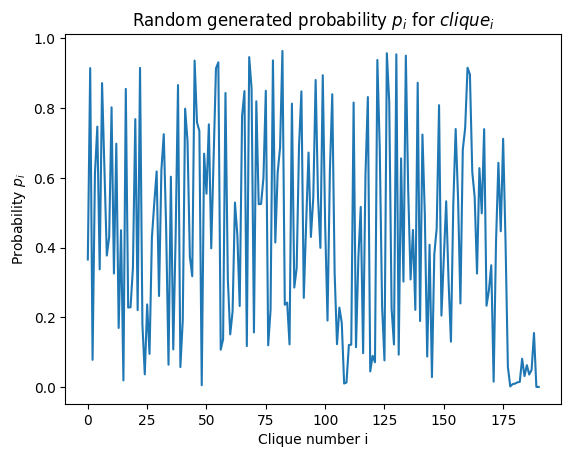

In [148]:
plt.plot(probabilities_clique_complex)
plt.xlabel('Clique number i')
plt.ylabel('Probability $p_i$')
plt.title('Random generated probability $p_i$ for $clique_i$')
plt.show()

In [158]:
from itertools import combinations

def nodes_probabilities(clique_complex, distribution_type='uniform', pareto_constant=-0.1):

    clique_dict = {}
    
    # Create a dictionary to group sets by their length
    sets_by_length = defaultdict(list)

    # Group sets by length
    for s in clique_complex:
        sets_by_length[len(s)].append(s)

    # Convert the dictionary values to lists
    result = list(sets_by_length.values())

    # Create empty list
    probabilities_clique_complex = []

    # Generate probability list per clique dimension and add
    probabilities_nodes = generate_probability_list(len(result[0]), pareto_constant, distribution_type)

    # Normalise the probability list for all clique dimensions together
    probabilities_nodes = np.abs(probabilities_nodes).astype(float)  # Convert to float
    probabilities_nodes /= probabilities_nodes.sum()

    for i in range(0, nodes_amount):
        clique_dict['{' + ', '.join(map(str, clique_complex[i])) + '}']=probabilities_nodes[i]

    return result, clique_dict


def clique_complex_probabilities(clique_complex, clique_dict):

    for clique in clique_complex:
        
        # Convert set to tuple and obtain all possible combinations with length smaller than the original set
        combinations_in_clique = [set(combination) for r in range(1, len(clique)) for combination in combinations(tuple(clique), r)]

        prior_element_prob = 1

        for element in combinations_in_clique:
            element_prob = clique_dict['{' + ', '.join(map(str, element)) + '}']  # to convert the set element into a string, so it is interpretable for dictionary
            prior_element_prob *= element_prob

        posterior_element_prob = prior_element_prob * np.random.rand() # Use a uniform distribution to sample the probability of each simplex

        clique_dict['{' + ', '.join(map(str, clique)) + '}']=posterior_element_prob
    
    return clique_dict

In [162]:
result, clique_dict = nodes_probabilities(clique_complex, distribution_type='uniform', pareto_constant=-0.1)

probabilities_clique_complex = clique_complex_probabilities(clique_complex, clique_dict) # Use clique_complex[len(result[0]):] after generating node_probabilities
probabilities_clique_complex = list(clique_dict.values())

# Normalise so the sum equals 1, since probability distribution
probabilities_clique_complex = np.abs(probabilities_clique_complex).astype(float)  # Convert to float
probabilities_clique_complex /= probabilities_clique_complex.sum()

print(clique_dict)
print(probabilities_clique_complex)

{'{0}': 0.711341045135093, '{1}': 0.2059486907155127, '{2}': 0.40557786366552495, '{3}': 0.9916238544144612, '{4}': 0.4116476241073308, '{5}': 0.9101276723746374, '{6}': 0.021237178775188714, '{7}': 0.42295998877076735, '{8}': 0.5097138883542537, '{9}': 0.6768248594494641, '{10}': 0.4996939012275782, '{11}': 0.2735187919729374, '{12}': 0.8131064401039266, '{13}': 0.6943042836740664, '{14}': 0.007323379804763608, '{15}': 0.6071275251202634, '{16}': 0.5561962859165785, '{17}': 0.9704660291436333, '{18}': 0.9663962516631104, '{19}': 0.7391054262696971, '{20}': 0.1666612075382653, '{21}': 0.619189564711466, '{22}': 0.8624412922943778, '{23}': 0.7994536336719794, '{24}': 0.9845068858166167, '{25}': 0.9910385085712468, '{26}': 0.3547711582074685, '{27}': 0.8818151858621963, '{28}': 0.28331134246063294, '{29}': 0.88080432223602, '{30}': 0.8582277743998127, '{31}': 0.11349633971233863, '{32}': 0.9449878979362909, '{33}': 0.6351163408532938, '{34}': 0.22250585677277068, '{35}': 0.82512618859921

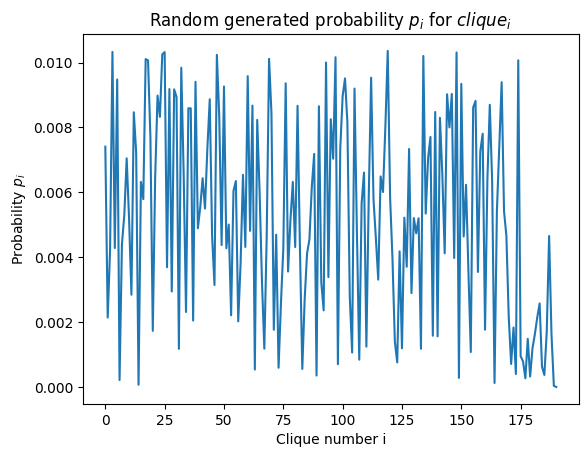

In [163]:
plt.plot(probabilities_clique_complex)
plt.xlabel('Clique number i')
plt.ylabel('Probability $p_i$')
plt.title('Random generated probability $p_i$ for $clique_i$')
plt.show()

# NEXT STEP: Integrate the clique prob generator into one function